First, import necessary libraries.

In [263]:
import sys
import os
import json
import math
import re
import itertools
from copy import deepcopy
from collections import defaultdict
from dataclasses import dataclass
from datetime import timedelta, datetime

## Core Data Science Libraries

# Main matplotlib usage is with `plt.whatever`
import matplotlib.pyplot as plt
# Sometimes you need style stuff via `mpl.whatever`
import matplotlib as mpl
# Statistic functions like `st.f_oneway`, `st.pearsonr`, etc.
import scipy.stats as st
# Your entire life is now pd.DataFrame(), pd.concat, etc.
import pandas as pd
# Real plotters user Seaborn over Matplotlib: sns.histplot, sns.jointplot, sns.lmplot, etc.
import seaborn as sns
# Sometimes you have to use numpy stuff, but almost always better to stay in Pandas
import numpy as np
# Specifically for IRR calculation
import krippendorff

## Quality of Life Libraries

# Progress bars! Just do:
#   for an_item in tqdm(an_iterable):
from tqdm.notebook import tqdm

# Need to render HTML or Code? Combine them with `display`
# Sometimes you will want to `print`, and sometimes `display`
from IPython.display import display, HTML, Code

## More Situational Libraries

# Situational, but sometimes natsorting is helpful
from natsort import index_natsorted, natsorted, order_by_index, natsort_keygen

# Some more useful statistic related functions in here
import sklearn.metrics as metrics

# More stats stuff, mixed effects models, generalized linear models, ODEs, etc.
import statsmodels as sm

# Probably won't need to use hidden markov models
#from hmmlearn import hmm

Style graphs to look more like the surrounding paper.

In [264]:
# At the minimum, make the background white so you can copy/paste into Discord :)
mpl.rcParams['figure.facecolor'] = 'white'

# Calculations I did one time for LaTeX papers, hope they're accurate..?
COLUMN_WIDTH = 240/72.27
TEXT_WIDTH = 504/72.27

# I liked this style, but use your best judgement
plt.style.use('seaborn-v0_8-whitegrid')

# Setup nice fonts for an ACM LaTeX paper
nice_fonts = {
    # Ideally, you should enable this if you have LaTeX installed
    # It'll make the graphs match the paper font much more closely.
    # "text.usetex": True,
    "text.usetex": False,
    
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
}
mpl.rcParams.update(nice_fonts)

# Stop using scientific notation, show two decimal places instead.
pd.set_option('display.float_format', '{:.2f}'.format)

Some helper functions:

In [265]:
def save_figure(filename, fig=None, folder='reports/figures/'):
    """ Helper function to quickly save figures for the paper. """
    if fig is None:
        fig = plt
    fig.savefig(os.path.join(folder, filename), format='pdf', bbox_inches='tight')

def display_code(data):
    return display(Code(data))

display_code("a = 0")

def set_size(width, fraction=1, subplots=(1, 1)):
    """ Set figure dimensions to avoid scaling in LaTeX.
    Parameters
    ----------
    width: float or string
            Document width in points, or string of predefined document type
    fraction: float, optional
            Fraction of the width which you wish the figure to occupy
    subplots: array-like, optional
            The number of rows and columns of subplots.
    Returns
    -------
    fig_dim: tuple
            Dimensions of figure in inches
    """
    if width == 'thesis':
        width_pt = 426.79135
    elif width == 'beamer':
        width_pt = 307.28987
    elif width == 'pnas':
        width_pt = 246.09686
    else:
        width_pt = width

    # Width of figure (in pts)
    fig_width_pt = width_pt * fraction
    # Convert from pt to inches
    inches_per_pt = 1 / 72.27

    # Golden ratio to set aesthetic figure height
    # https://disq.us/p/2940ij3
    golden_ratio = (5**.5 - 1) / 2

    # Figure width in inches
    fig_width_in = fig_width_pt * inches_per_pt
    # Figure height in inches
    fig_height_in = fig_width_in * golden_ratio * (subplots[0] / subplots[1])

    return fig_width_in, fig_height_in

def tex_escape(text):
    """
        :param text: a plain text message
        :return: the message escaped to appear correctly in LaTeX
    """
    conv = {
        '&': r'\&',
        '%': r'\%',
        '$': r'\$',
        '#': r'\#',
        '_': r'\_',
        '{': r'\{',
        '}': r'\}',
        '~': r'\textasciitilde{}',
        '^': r'\^{}',
        '\\': r'\textbackslash{}',
        '<': r'\textless{}',
        '>': r'\textgreater{}',
    }
    regex = re.compile('|'.join(re.escape(str(key)) for key in sorted(conv.keys(), key = lambda item: - len(item))))
    return regex.sub(lambda match: conv[match.group()], text)

### Good Research Stuff
# Choose a consistent alpha threshold for P-Value calculations
ALPHA = .05

def proportion_stats(incidences, total, label=None):
    """ Pretty prints a proportion with APA-style statistics. """
    proportion = incidences/total
    rounded_proportion = round(100*proportion*10)/10
    standard_deviation = math.sqrt(proportion*(1-proportion))/math.sqrt(total)
    rounded_sd = round(100*standard_deviation)/100
    result = f"n={incidences}, M={rounded_proportion}%, SD={rounded_sd}"
    if label is None:
        return result
    else:
        print(label, result)
print(proportion_stats(50, 100))
proportion_stats(75, 103, 'Test Case')

def quantitative_summarized(dataframe, x=None, y=None, hue=None, palette='Set1', ax=None, verbose=True, swarm=False):
    """
    Helper function that gives a quick summary of quantitative data
    Arguments
    =========
    dataframe: pandas dataframe
    x: str. horizontal axis to plot the labels of categorical data (usually the target variable)
    y: str. vertical axis to plot the quantitative data
    hue: str. if you want to compare it another categorical variable (usually the target variable if x is another variable)
    palette: array-like. Colour of the plot
    swarm: if swarm is set to True, a swarm plot would be overlaid
    Returns
    =======
    Quick Stats of the data and also the box plot of the distribution
    """
    series = dataframe[y]
    print(series.describe())
    print('mode: ', series.mode())
    if verbose:
        print('='*80)
        print(series.value_counts())

    sns.boxplot(x=x, y=y, hue=hue, data=dataframe, palette=palette, ax=ax)

    if swarm:
        sns.swarmplot(x=x, y=y, hue=hue, data=dataframe,
                      palette=palette, ax=ax)

    plt.show()

a = 0

n=50, M=50.0%, SD=0.05
Test Case n=75, M=72.8%, SD=0.04


With the setup taken care of, load the data to be analyzed.

In [266]:
data = {
    'unincluded': {},
    'included_1': {},
    'included_2': {}
}
data_fields = ('accurate', 'concise', 'clear', 'jargon', 'sentiment')

parent_dir = os.path.dirname(os.getcwd()).rstrip("\\/") + '/chosen_problems_st3-3_as3-3_at1_v1'
no_question_files = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results') if entry.endswith('.ini')]
question_files1 = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results_include_question') if entry.endswith('.ini')]
question_files2 = [entry for entry in os.listdir(f'{parent_dir}/_feedback_results_include_question2') if entry.endswith('.ini')]

def add_data(path, data_set):
    global data
    
    filename = file.split('/')[-1].split('\\')[-1]
    data[data_set][filename] = {}
    
    with open(path, encoding='utf-8') as ini_file:
        line_num = 0
        assignment = ''
        student = ''
        for line in ini_file.readlines():
            line_num += 1
            if line.startswith('[global]'):
                continue
            if line.startswith('[') and '.' not in line:
                assignment = line.strip('[]\n')
                data[data_set][filename][assignment] = {}
                continue
            elif line.startswith('[') and '.' in line:
                student = line.split('.')[1].split('_')[0]
                data[data_set][filename][assignment][student] = {}
                continue
            
            if len(assignment) == len(student) == 0:
                continue
            
            if line.startswith('instructor_feedback'):
                parts = [i.strip() for i in line.split('=')]
                try:
                    data[data_set][filename][assignment][student][parts[0]] = max(1, min(int(parts[1]), 5))  # clamp to 1-5 inclusive
                except (IndexError, ValueError):
                    print(f'Missing value for {parts[0]} at line {line_num} in {file}')

#for file in no_question_files:
#    add_data(f'{parent_dir}/_feedback_results/{file}', 'unincluded')

for file in question_files1:
    add_data(f'{parent_dir}/_feedback_results_include_question/{file}', 'included_1')

for file in question_files2:
    add_data(f'{parent_dir}/_feedback_results_include_question2/{file}', 'included_2')

Convert the loaded data to a pandas DataFrame.

In [267]:
records = [
    [data_set, filename, assignment_name, student_name, score_category, score]
    for data_set in data.keys()
    for filename, file in data[data_set].items()
    for assignment_name, assignment in file.items()
    for student_name, student in assignment.items()
    for score_category, score in student.items()
]
for record in records:
    # Only works with gpt-4-0613
    # Next time add this data to the ini [global] section
    filename_tokens = record[1].split('-')
    record.append(float(filename_tokens[4]))  # temp
    record.append(float(filename_tokens[6]))  # top_p
    #record.append(float(filename_tokens[7].split('.')[0]))  # trial

df = pd.DataFrame.from_records(records, columns=['data_set', 'filename', 'assignment_name', 'student_name', 'score_category', 'score', 'temp', 'top_p'])
# Show me the dataframe
df.head()

,data_set,filename,assignment_name,student_name,score_category,score,temp,top_p
0,included_1,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_advanced_plotting_code_basic_scatter,Beedrill,instructor_feedback_gpt_accurate,4,0.00,0.00
1,included_1,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_advanced_plotting_code_basic_scatter,Beedrill,instructor_feedback_gpt_concise,4,0.00,0.00
2,included_1,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_advanced_plotting_code_basic_scatter,Beedrill,instructor_feedback_gpt_clear,5,0.00,0.00
3,included_1,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_advanced_plotting_code_basic_scatter,Beedrill,instructor_feedback_gpt_jargon,1,0.00,0.00
4,included_1,gpt-4-0613-temp-0.0-top_p-0.0-0.ini,bakery_advanced_plotting_code_basic_scatter,Beedrill,instructor_feedback_gpt_sentiment,4,0.00,0.00


Compute Krippendorff's Alpha for the data.

In [268]:
MATCH_COLUMNS = ['filename', 'assignment_name', 'student_name', 'score_category']
left = df[df.data_set == 'included_1'].set_index(MATCH_COLUMNS).score.rename('left')
right = df[df.data_set == 'included_2'].set_index(MATCH_COLUMNS).score.rename('right')
side_by_side = pd.concat([left, right], axis=1)

print(st.pearsonr(side_by_side.left, side_by_side.right))
print(st.spearmanr(side_by_side.left, side_by_side.right))
print('Overall IRR:', krippendorff.alpha(reliability_data=side_by_side.T.values, level_of_measurement='ordinal'))

print()
for column in ['assignment_name', 'student_name', 'filename', 'score_category']:
    print(column, 'IRR scores:')
    for col_value, df_col in side_by_side.groupby(by=[column]):
        alpha = krippendorff.alpha(reliability_data=df_col.T.values, level_of_measurement='ordinal')
        print(f"\t{col_value[0]}: {alpha}")

PearsonRResult(statistic=0.6041177033411959, pvalue=0.0)
SignificanceResult(statistic=0.6128512081109019, pvalue=0.0)
Overall IRR: 0.608719044782573

assignment_name IRR scores:
	bakery_advanced_plotting_code_basic_scatter: 0.39660338033807574
	bakery_for_composition_code_highest_filter: 0.42348827018653135
	bakery_functions_flow_code_timely_extraction: 0.32479713865627646
	bakery_if_patterns_make_pig_latin: 0.33640172016604175
	bakery_intro_import_code_import_variable: 0.5392740108024614
	bakery_intro_programs_code_try_blockpy: 0.8652873815341733
	bakery_nesting_list_dataclasses_code_good_job: 0.39691144471362194
	bakery_structures_lists_code_book_list: 0.6838300164457983
	bakery_structures_lists_code_emptiness: 0.8864255326687613
student_name IRR scores:
	Beedrill: 0.6410582207170665
	Buizel: 0.6041330419221349
	Darumaka: 0.6530471761895797
	Elgyem: 0.45446756929266097
	Girafarig: 0.5907744457638235
	Lapras: 0.6190699606978803
	Liepard: 0.5692011967973064
	Nosepass: 0.641476226870905

Compute the mean score for each category per dataset.

In [269]:
df[['data_set', 'score_category', 'score']].groupby(['data_set', 'score_category']).describe()

score                      \
                                                 count mean  std  min  25%   
data_set   score_category                                                    
included_1 instructor_feedback_gpt_accurate    1185.00 4.83 0.53 1.00 5.00   
           instructor_feedback_gpt_clear       1185.00 4.77 0.51 1.00 5.00   
           instructor_feedback_gpt_concise     1185.00 3.90 1.09 1.00 3.00   
           instructor_feedback_gpt_jargon      1185.00 1.84 1.03 1.00 1.00   
           instructor_feedback_gpt_sentiment   1185.00 4.07 0.90 1.00 3.00   
           instructor_feedback_pedal_accurate  1185.00 4.28 1.16 1.00 3.00   
           instructor_feedback_pedal_clear     1185.00 3.58 1.54 1.00 2.00   
           instructor_feedback_pedal_concise   1185.00 4.43 0.93 1.00 4.00   
           instructor_feedback_pedal_jargon    1185.00 2.24 1.52 1.00 1.00   
           instructor_feedback_pedal_sentiment 1185.00 3.43 1.18 1.00 3.00   
included_2 instructor_feedback_gpt_accurate    1185.00 4.63 0.68 1.00 4.00   
           instructor_feedback_gpt_clear       1185.00 4.55 0.75 1.00 4.00   
           instructor_feedback_gpt_concise     1185.00 3.79 1.16 1.00 3.00   
           instructor_feedback_gpt_jargon      1185.00 1.77 1.00 1.00 1.00   
           instructor_feedback_gpt_sentiment   1185.00 3.91 0.96 1.00 3.00   
           instructor_feedback_pedal_accurate  1185.00 4.26 1.14 1.00 4.00   
           instructor_feedback_pedal_clear     1185.00 3.69 1.27 1.00 3.00   
           instructor_feedback_pedal_concise   1185.00 4.32 1.03 1.00 4.00   
           instructor_feedback_pedal_jargon    1185.00 2.11 1.38 1.00 1.00   
           instructor_feedback_pedal_sentiment 1185.00 3.43 1.14 1.00 3.00   

                                                               
                                                50%  75%  max  
data_set   score_category                                      
included_1 instructor_feedback_gpt_accurate    5.00 5.00 5.00  
           instructor_feedback_gpt_clear       5.00 5.00 5.00  
           instructor_feedback_gpt_concise     4.00 5.00 5.00  
           instructor_feedback_gpt_jargon      1.00 3.00 5.00  
           instructor_feedback_gpt_sentiment   4.00 5.00 5.00  
           instructor_feedback_pedal_accurate  5.00 5.00 5.00  
           instructor_feedback_pedal_clear     4.00 5.00 5.00  
           instructor_feedback_pedal_concise   5.00 5.00 5.00  
           instructor_feedback_pedal_jargon    1.00 4.00 5.00  
           instructor_feedback_pedal_sentiment 3.00 5.00 5.00  
included_2 instructor_feedback_gpt_accurate    5.00 5.00 5.00  
           instructor_feedback_gpt_clear       5.00 5.00 5.00  
           instructor_feedback_gpt_concise     4.00 5.00 5.00  
           instructor_feedback_gpt_jargon      1.00 2.00 5.00  
           instructor_feedback_gpt_sentiment   4.00 5.00 5.00  
           instructor_feedback_pedal_accurate  5.00 5.00 5.00  
           instructor_feedback_pedal_clear     4.00 5.00 5.00  
           instructor_feedback_pedal_concise   5.00 5.00 5.00  
           instructor_feedback_pedal_jargon    1.00 3.00 5.00  
           instructor_feedback_pedal_sentiment 3.00 5.00 5.00

Compute the mean score for each category by assignment name.

In [270]:
df[['assignment_name', 'score_category', 'score']].groupby(['assignment_name', 'score_category']).describe()

score  \
                                                                                 count   
assignment_name                             score_category                               
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    240.00   
                                            instructor_feedback_gpt_clear       240.00   
                                            instructor_feedback_gpt_concise     240.00   
                                            instructor_feedback_gpt_jargon      240.00   
                                            instructor_feedback_gpt_sentiment   240.00   
...                                                                                ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  240.00   
                                            instructor_feedback_pedal_clear     240.00   
                                            instructor_feedback_pedal_concise   240.00   
                                            instructor_feedback_pedal_jargon    240.00   
                                            instructor_feedback_pedal_sentiment 240.00   

                                                                                      \
                                                                                mean   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    4.58   
                                            instructor_feedback_gpt_clear       4.54   
                                            instructor_feedback_gpt_concise     3.43   
                                            instructor_feedback_gpt_jargon      2.02   
                                            instructor_feedback_gpt_sentiment   3.74   
...                                                                              ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  5.00   
                                            instructor_feedback_pedal_clear     4.90   
                                            instructor_feedback_pedal_concise   5.00   
                                            instructor_feedback_pedal_jargon    1.00   
                                            instructor_feedback_pedal_sentiment 5.00   

                                                                                      \
                                                                                 std   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    0.68   
                                            instructor_feedback_gpt_clear       0.64   
                                            instructor_feedback_gpt_concise     1.11   
                                            instructor_feedback_gpt_jargon      1.02   
                                            instructor_feedback_gpt_sentiment   0.79   
...                                                                              ...   
bakery_structures_lists_code_emptiness      instructor_feedback_pedal_accurate  0.00   
                                            instructor_feedback_pedal_clear     0.29   
                                            instructor_feedback_pedal_concise   0.00   
                                            instructor_feedback_pedal_jargon    0.00   
                                            instructor_feedback_pedal_sentiment 0.06   

                                                                                      \
                                                                                 min   
assignment_name                             score_category                             
bakery_advanced_plotting_code_basic_scatter instructor_feedback_gpt_accurate    2.00   
  

Compute the mean score for each category by student name.

In [271]:
df[['student_name', 'score_category', 'score']].groupby(['student_name', 'score_category']).describe()

score                      \
                                                  count mean  std  min  25%   
student_name score_category                                                   
Beedrill     instructor_feedback_gpt_accurate    270.00 4.75 0.60 1.00 5.00   
             instructor_feedback_gpt_clear       270.00 4.74 0.55 3.00 5.00   
             instructor_feedback_gpt_concise     270.00 3.86 1.09 1.00 3.00   
             instructor_feedback_gpt_jargon      270.00 1.73 0.98 1.00 1.00   
             instructor_feedback_gpt_sentiment   270.00 4.34 0.81 2.00 4.00   
...                                                 ...  ...  ...  ...  ...   
Nuzleaf      instructor_feedback_pedal_accurate  270.00 4.56 0.86 1.00 5.00   
             instructor_feedback_pedal_clear     270.00 3.94 1.30 1.00 3.00   
             instructor_feedback_pedal_concise   270.00 4.60 0.75 2.00 4.00   
             instructor_feedback_pedal_jargon    270.00 1.97 1.33 1.00 1.00   
             instructor_feedback_pedal_sentiment 270.00 3.61 1.13 1.00 3.00   

                                                                 
                                                  50%  75%  max  
student_name score_category                                      
Beedrill     instructor_feedback_gpt_accurate    5.00 5.00 5.00  
             instructor_feedback_gpt_clear       5.00 5.00 5.00  
             instructor_feedback_gpt_concise     4.00 5.00 5.00  
             instructor_feedback_gpt_jargon      1.00 2.00 4.00  
             instructor_feedback_gpt_sentiment   5.00 5.00 5.00  
...                                               ...  ...  ...  
Nuzleaf      instructor_feedback_pedal_accurate  5.00 5.00 5.00  
             instructor_feedback_pedal_clear     5.00 5.00 5.00  
             instructor_feedback_pedal_concise   5.00 5.00 5.00  
             instructor_feedback_pedal_jargon    1.00 3.00 5.00  
             instructor_feedback_pedal_sentiment 3.00 5.00 5.00  

[90 rows x 8 columns]

Compute the mean score for each category for each temperature and top p combination.

In [272]:
df[['filename', 'score_category', 'score']].groupby(['filename', 'score_category']).describe()

score  \
                                                                         count   
filename                            score_category                               
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    158.00   
                                    instructor_feedback_gpt_clear       158.00   
                                    instructor_feedback_gpt_concise     158.00   
                                    instructor_feedback_gpt_jargon      158.00   
                                    instructor_feedback_gpt_sentiment   158.00   
...                                                                        ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  158.00   
                                    instructor_feedback_pedal_clear     158.00   
                                    instructor_feedback_pedal_concise   158.00   
                                    instructor_feedback_pedal_jargon    158.00   
                                    instructor_feedback_pedal_sentiment 158.00   

                                                                              \
                                                                        mean   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    4.51   
                                    instructor_feedback_gpt_clear       4.11   
                                    instructor_feedback_gpt_concise     3.54   
                                    instructor_feedback_gpt_jargon      2.16   
                                    instructor_feedback_gpt_sentiment   3.78   
...                                                                      ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  4.16   
                                    instructor_feedback_pedal_clear     3.14   
                                    instructor_feedback_pedal_concise   4.38   
                                    instructor_feedback_pedal_jargon    2.53   
                                    instructor_feedback_pedal_sentiment 3.30   

                                                                              \
                                                                         std   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    0.66   
                                    instructor_feedback_gpt_clear       0.78   
                                    instructor_feedback_gpt_concise     1.07   
                                    instructor_feedback_gpt_jargon      1.07   
                                    instructor_feedback_gpt_sentiment   0.89   
...                                                                      ...   
gpt-4-0613-temp-2.0-top_p-0.0-2.ini instructor_feedback_pedal_accurate  1.23   
                                    instructor_feedback_pedal_clear     1.65   
                                    instructor_feedback_pedal_concise   0.96   
                                    instructor_feedback_pedal_jargon    1.69   
                                    instructor_feedback_pedal_sentiment 1.26   

                                                                              \
                                                                         min   
filename                            score_category                             
gpt-4-0613-temp-0.0-top_p-0.0-0.ini instructor_feedback_gpt_accurate    2.00   
                                    instructor_feedback_gpt_clear       3.00   
                                    instructor_feedback_gpt_concise     1.00   
                                    instructor_feedback_gpt_jargon      1.00   
                                    instructor_feedback_gpt_sentiment   3.00   
...                                       

Compute the mean score for each category.

In [273]:
df[['score_category', 'score']].groupby(['score_category']).describe()

score                                   
                                      count mean  std  min  25%  50%  75%  max
score_category                                                                
instructor_feedback_gpt_accurate    2370.00 4.73 0.62 1.00 5.00 5.00 5.00 5.00
instructor_feedback_gpt_clear       2370.00 4.66 0.65 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_concise     2370.00 3.85 1.13 1.00 3.00 4.00 5.00 5.00
instructor_feedback_gpt_jargon      2370.00 1.80 1.02 1.00 1.00 1.00 2.00 5.00
instructor_feedback_gpt_sentiment   2370.00 3.99 0.93 1.00 3.00 4.00 5.00 5.00
instructor_feedback_pedal_accurate  2370.00 4.27 1.15 1.00 3.00 5.00 5.00 5.00
instructor_feedback_pedal_clear     2370.00 3.63 1.41 1.00 2.00 4.00 5.00 5.00
instructor_feedback_pedal_concise   2370.00 4.38 0.98 1.00 4.00 5.00 5.00 5.00
instructor_feedback_pedal_jargon    2370.00 2.17 1.45 1.00 1.00 1.00 4.00 5.00
instructor_feedback_pedal_sentiment 2370.00 3.43 1.16 1.00 3.00 3.00 5.00 5.00

Compute the number of graded items.

In [295]:
df[(df.data_set == 'included_1')][['score_category', 'score']].groupby(['score_category']).value_counts()

score_category                       score
instructor_feedback_gpt_accurate     5        1045
                                     4          88
                                     3          43
                                     2           5
                                     1           4
instructor_feedback_gpt_clear        5         949
                                     4         212
                                     3          14
                                     2           8
                                     1           2
instructor_feedback_gpt_concise      5         464
                                     4         312
                                     3         263
                                     2         124
                                     1          22
instructor_feedback_gpt_jargon       1         627
                                     2         231
                                     3         222
                                     4 

Create a helper function for displaying diverging stacked bar charts.

In [274]:
def diverging_stacked_bar_chart(results, title=None, inline_legend=False, category_colors='coolwarm_r', category_names=('(1) Strongly Disagree', '(2)', '(3)', '(4)', '(5) Strongly Agree')):
    """
    Parameters
    ----------
    results : dict
        A mapping from question labels to a list of answers per category.
        It is assumed all lists contain the same number of entries and that
        it matches the length of *category_names*. The order is assumed
        to be from 'Strongly disagree' to 'Strongly agree'
    category_names : list of str
        The category labels.
    """
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    middle_index = data.shape[1] // 2
    offsets = data[:, range(middle_index)].sum(axis=1) + data[:, middle_index]/2
    
    # Color Mapping
    category_colors = plt.get_cmap(category_colors)(
        np.linspace(0.15, 0.85, data.shape[1]))
    
    fig, ax = plt.subplots(figsize=(4.5, 5))
    
    # Plot Bars
    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths - offsets
        rects = ax.barh(labels, widths, left=starts, height=0.5, label=colname, color=color)
    
    # Add Zero Reference Line
    ax.axvline(0, linestyle='--', color='black', alpha=.25)
    
    # X Axis
    bound = max(abs(starts[0] - widths[0] - offsets[0]), abs(starts[-1] + widths[-1] + offsets[-1]))
    ax.set_xlim(-bound, bound)
    ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')
    ax.xaxis.set_major_formatter(lambda x, pos: str(abs(int(x))))
    
    # Y Axis
    ax.invert_yaxis()
    
    # Remove spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    # Legend
    if inline_legend:
        ax.legend(ncol=1, fontsize='x-small')
    else:
        ax.legend(ncol=len(category_names), bbox_to_anchor=(0.45, 1), loc='lower center', fontsize='xx-small')
    
    # Set Background Color
    fig.set_facecolor('#FFFFFF')
    
    # Title
    if not inline_legend and title is not None:
        plt.title(title, pad=28)

    return fig, ax

questions = (
    'How accurate is the feedback response to the prompt and student code?',
    'How concise is the feedback?',
    'How clear is the feedback?',
    'The feedback has technical jargon.',
    'Does the feedback make you feel positive or negative?'
)

def diverging_stacked_bar_chart_results(results, titles=questions):
    category_labels = {
        'accurate': ('(1) Inaccurate', '(2)', '(3)', '(4)', '(5) Accurate'),
        'concise': ('(1) Not Concise', '(2)', '(3)', '(4)', '(5) Concise'),
        'clear': ('(1) Not Clear', '(2)', '(3)', '(4)', '(5) Clear'),
        'jargon': ('(1) Strongly Disagree', '(2)', '(3)', '(4)', '(5) Strongly Agree'),
        'sentiment': ('(1) Negative', '(2)', '(3) Neutral', '(4)', '(5) Positive')
    }
    
    for i, data_field in enumerate(data_fields):
        subresults = {
            'Alchemy': results[f'instructor_feedback_gpt_{data_field}'],
            'Non-LLM': results[f'instructor_feedback_pedal_{data_field}']
        }
        fig, ax = diverging_stacked_bar_chart(subresults, titles[i], category_colors=('coolwarm_r' if i != 3 else 'coolwarm'), category_names=category_labels[data_field])
        plt.title(titles[i], pad=18, fontsize='x-small')
        fig.set_figheight(0.5)
        if i != 4:
            ax.spines['bottom'].set_visible(False)
            plt.tick_params(
                axis='x',          # changes apply to the x-axis
                which='both',      # both major and minor ticks are affected
                bottom=False,      # ticks along the bottom edge are off
                top=False,         # ticks along the top edge are off
                labelbottom=False  # labels along the bottom edge are off
            )
        plt.show()

Create a graph displaying the overall score distribution, and display the significance values for each score category.

C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


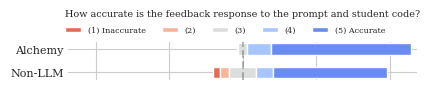

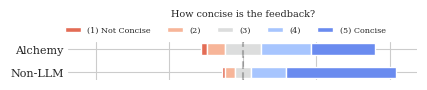

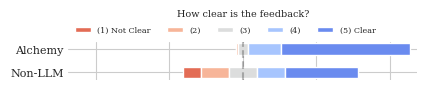

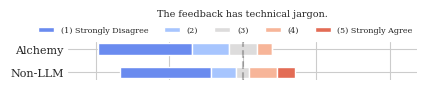

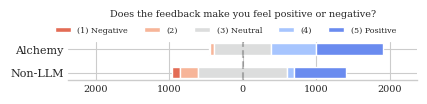

accurate:
	statistic = 3318996.5 
	pvalue = 1.2726657812667253e-43 
	effectsize = 0.5908947106054941
concise:
	statistic = 2005234.0 
	pvalue = 9.492539918424967e-76 
	effectsize = 0.35700012462390285
clear:
	statistic = 3953788.0 
	pvalue = 3.5528572381259365e-163 
	effectsize = 0.7039092737987146
jargon:
	statistic = 2542316.5 
	pvalue = 7.380092065755459e-10 
	effectsize = 0.45261914935284586
sentiment:
	statistic = 3593432.0 
	pvalue = 2.72822580360556e-70 
	effectsize = 0.639753600740622


In [275]:
results = {category: list(v.values) for category, v in df.groupby('score_category').score.value_counts().unstack('score_category').items()}
diverging_stacked_bar_chart_results(results)

for data_field in data_fields:
    gpt_scores = df[df.score_category == f'instructor_feedback_gpt_{data_field}']['score']
    pedal_scores = df[df.score_category == f'instructor_feedback_pedal_{data_field}']['score']
    U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
    print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Create graphs for each temperature and top p combination displaying the score distribution, and display the significance values for each score category for each combination.

C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


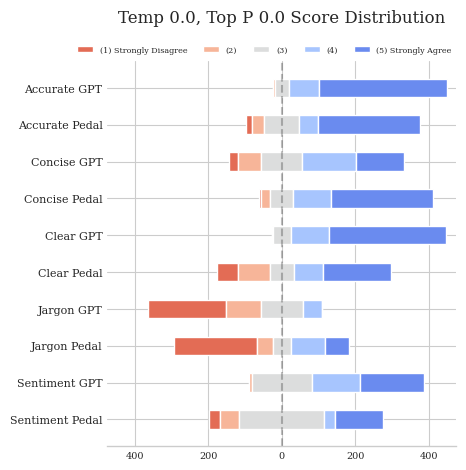

accurate:
	statistic = 134865.0 
	pvalue = 1.9651328023298998e-10 
	effectsize = 0.6002643807082199
concise:
	statistic = 72703.0 
	pvalue = 2.7793772811069403e-23 
	effectsize = 0.32359041464152827
clear:
	statistic = 155955.0 
	pvalue = 1.6146029581207326e-29 
	effectsize = 0.6941328846872831
jargon:
	statistic = 99095.5 
	pvalue = 0.0008692855330816969 
	effectsize = 0.44105957022556924
sentiment:
	statistic = 145919.0 
	pvalue = 3.0042661207336756e-17 
	effectsize = 0.6494641172176824


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


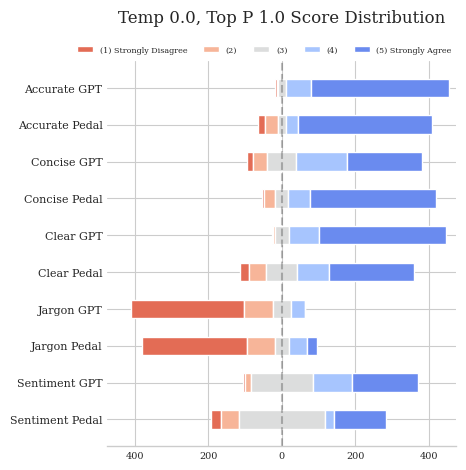

accurate:
	statistic = 117033.0 
	pvalue = 0.1228633598953586 
	effectsize = 0.520896757998184
concise:
	statistic = 79861.0 
	pvalue = 6.0730222651707346e-18 
	effectsize = 0.3554496252381207
clear:
	statistic = 144838.0 
	pvalue = 1.3599604632507816e-18 
	effectsize = 0.6446527443963752
jargon:
	statistic = 104400.5 
	pvalue = 0.02974355596162982 
	effectsize = 0.46467134896473145
sentiment:
	statistic = 139417.5 
	pvalue = 8.099858639951932e-12 
	effectsize = 0.6205268920578967


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


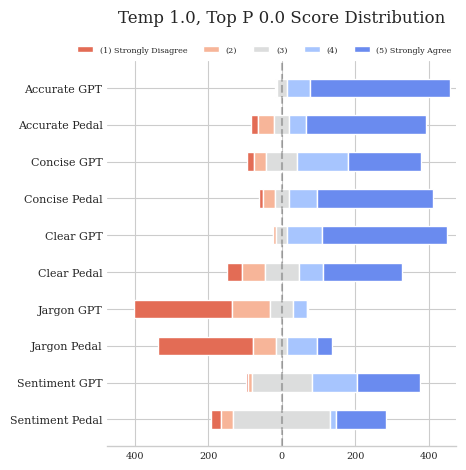

accurate:
	statistic = 128944.5 
	pvalue = 2.808411998489067e-07 
	effectsize = 0.573913101532874
concise:
	statistic = 85601.5 
	pvalue = 2.7784496083758107e-12 
	effectsize = 0.3809997507521943
clear:
	statistic = 151805.5 
	pvalue = 7.358185813532463e-26 
	effectsize = 0.6756640673681212
jargon:
	statistic = 101969.0 
	pvalue = 0.006561703019533702 
	effectsize = 0.4538490982570457
sentiment:
	statistic = 142544.0 
	pvalue = 1.6050732014044383e-14 
	effectsize = 0.634442486068828


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


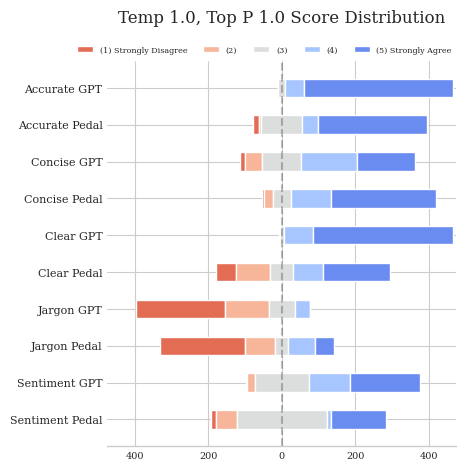

accurate:
	statistic = 141084.5 
	pvalue = 6.953533081316378e-19 
	effectsize = 0.6279464651320124
concise:
	statistic = 79406.5 
	pvalue = 6.090092690431599e-17 
	effectsize = 0.35342671224340827
clear:
	statistic = 167768.0 
	pvalue = 4.388373856153193e-50 
	effectsize = 0.7467108191351101
jargon:
	statistic = 99819.0 
	pvalue = 0.001392265896650999 
	effectsize = 0.4442797628585163
sentiment:
	statistic = 141198.5 
	pvalue = 3.0058203039469184e-13 
	effectsize = 0.628453862450818


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


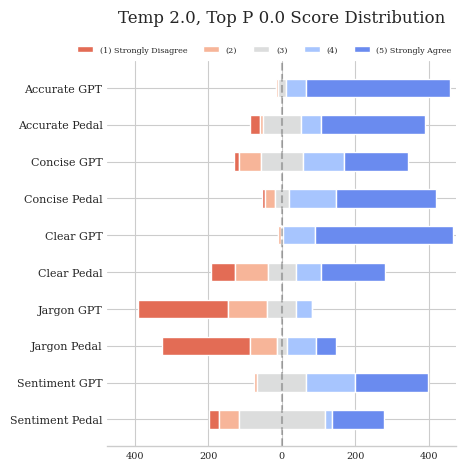

accurate:
	statistic = 142056.5 
	pvalue = 9.963355459877809e-19 
	effectsize = 0.6322726949028824
concise:
	statistic = 81917.0 
	pvalue = 1.0956507607587342e-14 
	effectsize = 0.36460058039131904
clear:
	statistic = 169755.0 
	pvalue = 1.7642088022381918e-52 
	effectsize = 0.7555546653848209
jargon:
	statistic = 100781.5 
	pvalue = 0.0030513835157597847 
	effectsize = 0.4485637095194858
sentiment:
	statistic = 149448.0 
	pvalue = 1.0761157444497055e-20 
	effectsize = 0.6651711798322918


In [276]:
temp_and_top_p_combos = [(temp, top_p) for temp in (0.0, 1.0, 2.0) for top_p in (0.0, 1.0) if not (temp == 2.0 and top_p == 1.0)]

for temp, top_p in temp_and_top_p_combos:
    results = {category: list(v.values) for category, v in df[(df.temp == temp) & (df.top_p == top_p)].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    results_sorted = {}
    for data_field in data_fields:
        results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
        results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
    fig, ax = diverging_stacked_bar_chart(results_sorted, f'Temp {temp}, Top P {top_p} Score Distribution')
    plt.show()

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp) & (df.top_p == top_p)]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & (df.temp == temp) & (df.top_p == top_p)]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Now compare the distribution by category, and display the significance values for each score category for each combination of the temperature and top p values.

C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


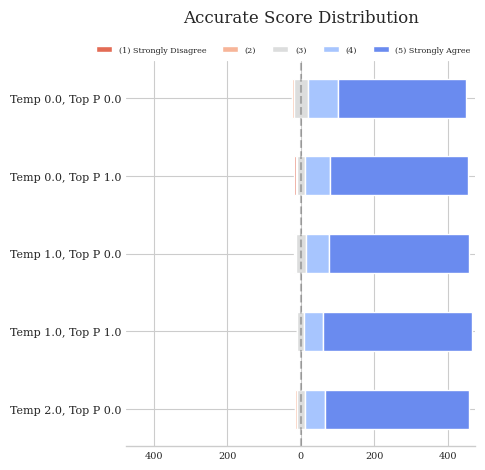

Significance (temp 1, top_p 1) and (temp 2, top_p 2)
accurate (0.0, 0.0) and (0.0, 1.0):
	statistic = 106080.0 
	pvalue = 0.045355424868678905 
	effectsize = 0.4721465577097687
accurate (0.0, 0.0) and (1.0, 0.0):
	statistic = 104903.5 
	pvalue = 0.016520667226378287 
	effectsize = 0.46691012836261997
accurate (0.0, 0.0) and (1.0, 1.0):
	statistic = 98757.0 
	pvalue = 4.553805969555698e-06 
	effectsize = 0.4395529562570101
accurate (0.0, 0.0) and (2.0, 0.0):
	statistic = 101876.5 
	pvalue = 0.0005587907284568072 
	effectsize = 0.45343739429222524
accurate (0.0, 1.0) and (0.0, 0.0):
	statistic = 118596.0 
	pvalue = 0.045355424868678905 
	effectsize = 0.5278534422902312
accurate (0.0, 1.0) and (1.0, 0.0):
	statistic = 111160.0 
	pvalue = 0.6904339984198242 
	effectsize = 0.4947568943723406
accurate (0.0, 1.0) and (1.0, 1.0):
	statistic = 105057.5 
	pvalue = 0.00929815882445165 
	effectsize = 0.4675955598283751
accurate (0.0, 1.0) and (2.0, 0.0):
	statistic = 108104.0 
	pvalue = 0.14121496

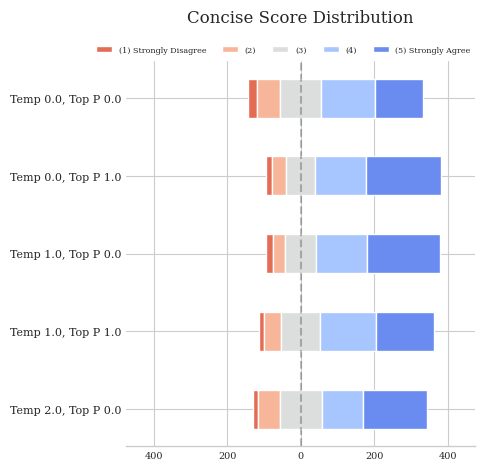

Significance (temp 1, top_p 1) and (temp 2, top_p 2)
concise (0.0, 0.0) and (0.0, 1.0):
	statistic = 90988.0 
	pvalue = 1.2975388962515955e-07 
	effectsize = 0.4049742740657658
concise (0.0, 0.0) and (1.0, 0.0):
	statistic = 91604.0 
	pvalue = 2.970870897657898e-07 
	effectsize = 0.4077159999287863
concise (0.0, 0.0) and (1.0, 1.0):
	statistic = 101542.0 
	pvalue = 0.007832769598030287 
	effectsize = 0.451948583738361
concise (0.0, 0.0) and (2.0, 0.0):
	statistic = 102952.0 
	pvalue = 0.02098532330200506 
	effectsize = 0.4582242874183268
concise (0.0, 1.0) and (0.0, 0.0):
	statistic = 133688.0 
	pvalue = 1.2975388962515955e-07 
	effectsize = 0.5950257259342342
concise (0.0, 1.0) and (1.0, 0.0):
	statistic = 112969.0 
	pvalue = 0.874258140434114 
	effectsize = 0.5028084886681266
concise (0.0, 1.0) and (1.0, 1.0):
	statistic = 123552.0 
	pvalue = 0.005257744473451747 
	effectsize = 0.5499118730972601
concise (0.0, 1.0) and (2.0, 0.0):
	statistic = 123578.0 
	pvalue = 0.005154661753564585

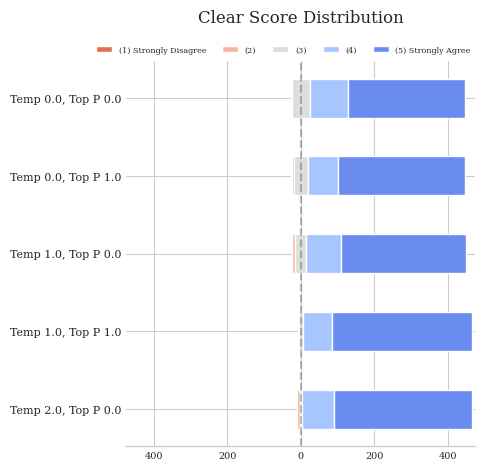

Significance (temp 1, top_p 1) and (temp 2, top_p 2)
clear (0.0, 0.0) and (0.0, 1.0):
	statistic = 106027.0 
	pvalue = 0.06349027918983435 
	effectsize = 0.4719106624650608
clear (0.0, 0.0) and (1.0, 0.0):
	statistic = 106353.5 
	pvalue = 0.07956832248807973 
	effectsize = 0.47336386618953513
clear (0.0, 0.0) and (1.0, 1.0):
	statistic = 95671.0 
	pvalue = 2.743683702382725e-07 
	effectsize = 0.42581762181986504
clear (0.0, 0.0) and (2.0, 0.0):
	statistic = 97098.0 
	pvalue = 3.2004828168914925e-06 
	effectsize = 0.43216899001228437
clear (0.0, 1.0) and (0.0, 0.0):
	statistic = 118649.0 
	pvalue = 0.06349027918983435 
	effectsize = 0.5280893375349393
clear (0.0, 1.0) and (1.0, 0.0):
	statistic = 112781.0 
	pvalue = 0.8934269341496086 
	effectsize = 0.5019717281774644
clear (0.0, 1.0) and (1.0, 1.0):
	statistic = 102387.0 
	pvalue = 0.0013698388469694219 
	effectsize = 0.45570955509266675
clear (0.0, 1.0) and (2.0, 0.0):
	statistic = 103849.5 
	pvalue = 0.006920008151814863 
	effectsize

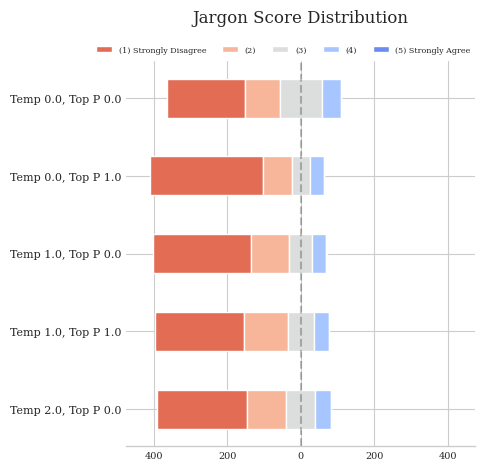

Significance (temp 1, top_p 1) and (temp 2, top_p 2)
jargon (0.0, 0.0) and (0.0, 1.0):
	statistic = 135832.0 
	pvalue = 7.898758687152507e-10 
	effectsize = 0.6045683562107212
jargon (0.0, 0.0) and (1.0, 0.0):
	statistic = 128220.5 
	pvalue = 4.481993940453005e-05 
	effectsize = 0.5706906834730902
jargon (0.0, 0.0) and (1.0, 1.0):
	statistic = 123229.0 
	pvalue = 0.005579037560175618 
	effectsize = 0.5484742473606438
jargon (0.0, 0.0) and (2.0, 0.0):
	statistic = 122573.5 
	pvalue = 0.009138651512823353 
	effectsize = 0.5455567127775107
jargon (0.0, 1.0) and (0.0, 0.0):
	statistic = 88844.0 
	pvalue = 7.898758687152507e-10 
	effectsize = 0.3954316437892788
jargon (0.0, 1.0) and (1.0, 0.0):
	statistic = 103818.5 
	pvalue = 0.021070670077197932 
	effectsize = 0.46208095212661787
jargon (0.0, 1.0) and (1.0, 1.0):
	statistic = 98205.0 
	pvalue = 0.00016808191207701265 
	effectsize = 0.43709608502910857
jargon (0.0, 1.0) and (2.0, 0.0):
	statistic = 98105.0 
	pvalue = 0.00014815462016113035

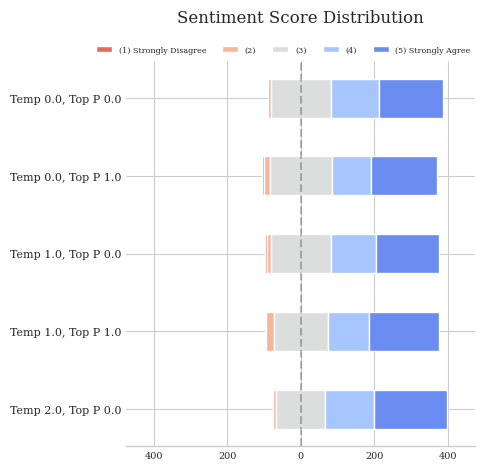

Significance (temp 1, top_p 1) and (temp 2, top_p 2)
sentiment (0.0, 0.0) and (0.0, 1.0):
	statistic = 115497.0 
	pvalue = 0.4271601269769886 
	effectsize = 0.5140602467553277
sentiment (0.0, 0.0) and (1.0, 0.0):
	statistic = 114293.0 
	pvalue = 0.6234359584064262 
	effectsize = 0.5087014189321512
sentiment (0.0, 0.0) and (1.0, 1.0):
	statistic = 110905.5 
	pvalue = 0.7189855145751838 
	effectsize = 0.49362415211237515
sentiment (0.0, 0.0) and (2.0, 0.0):
	statistic = 104675.5 
	pvalue = 0.05371083835399869 
	effectsize = 0.46589533372500846
sentiment (0.0, 1.0) and (0.0, 0.0):
	statistic = 109179.0 
	pvalue = 0.4271601269769886 
	effectsize = 0.4859397532446723
sentiment (0.0, 1.0) and (1.0, 0.0):
	statistic = 111146.5 
	pvalue = 0.7648633795835803 
	effectsize = 0.4946968078477452
sentiment (0.0, 1.0) and (1.0, 1.0):
	statistic = 108057.0 
	pvalue = 0.2821429329342503 
	effectsize = 0.4809458954227421
sentiment (0.0, 1.0) and (2.0, 0.0):
	statistic = 102032.5 
	pvalue = 0.00950814328

In [277]:
for data_field in data_fields:
    results = {}
    for temp, top_p in temp_and_top_p_combos:
        results[f'Temp {temp}, Top P {top_p}'] = \
            df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp) & (df.top_p == top_p)].score.value_counts().reindex(df.score.unique(), fill_value=0).sort_index().tolist()
    fig, ax = diverging_stacked_bar_chart(results, f'{data_field.capitalize()} Score Distribution')
    plt.show()
    
    print('Significance (temp 1, top_p 1) and (temp 2, top_p 2)')
    for temp1, top_p1 in temp_and_top_p_combos:
        for temp2, top_p2 in temp_and_top_p_combos:
            if temp1 == temp2 and top_p1 == top_p2:
                continue
            
            score1 = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp1) & (df.top_p == top_p1)]['score']
            score2 = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & (df.temp == temp2) & (df.top_p == top_p2)]['score']
            U, p = st.mannwhitneyu(score1, score2)
            print(data_field + f' ({temp1}, {top_p1}) and ({temp2}, {top_p2})' + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(score1) * len(score2)))

Create graphs for each student combination displaying the score distribution, and display the significance values for each score category for each combination.
Students are sorted based on competency in the overall course.

C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


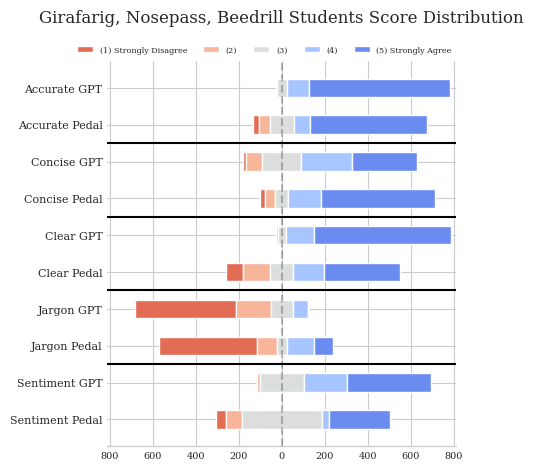

accurate:
	statistic = 383064.0 
	pvalue = 3.1140846739335226e-14 
	effectsize = 0.5838500228623685
concise:
	statistic = 235957.5 
	pvalue = 2.3831676276797833e-26 
	effectsize = 0.359636488340192
clear:
	statistic = 462333.5 
	pvalue = 8.552385905342812e-60 
	effectsize = 0.7046692577351014
jargon:
	statistic = 297455.0 
	pvalue = 0.00029065509915421816 
	effectsize = 0.4533683889650968
sentiment:
	statistic = 428511.5 
	pvalue = 5.442499298883583e-30 
	effectsize = 0.6531191891479957


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


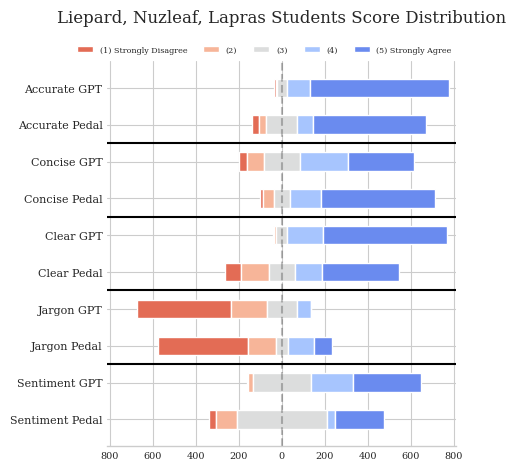

accurate:
	statistic = 386497.0 
	pvalue = 2.903804828066924e-15 
	effectsize = 0.5890824569425392
concise:
	statistic = 233571.0 
	pvalue = 1.1044583662191352e-27 
	effectsize = 0.35599908550525833
clear:
	statistic = 444669.0 
	pvalue = 1.1780044833205945e-43 
	effectsize = 0.6777457704618198
jargon:
	statistic = 297817.5 
	pvalue = 0.0004640330052922124 
	effectsize = 0.4539208962048468
sentiment:
	statistic = 423555.5 
	pvalue = 3.506418999869083e-27 
	effectsize = 0.6455654625819235


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


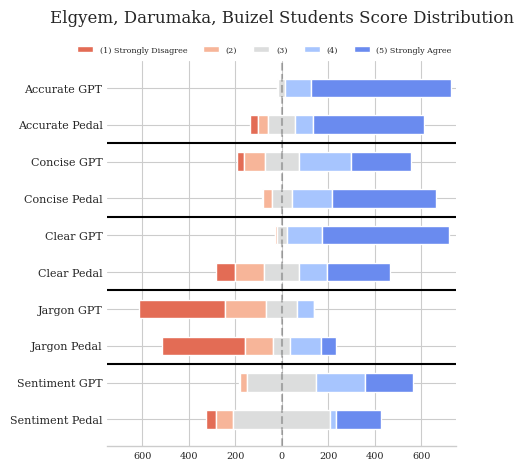

accurate:
	statistic = 337818.0 
	pvalue = 1.6217855779877317e-17 
	effectsize = 0.6005653333333333
concise:
	statistic = 199465.5 
	pvalue = 1.8699393090447685e-25 
	effectsize = 0.35460533333333333
clear:
	statistic = 411849.5 
	pvalue = 1.0795548919677678e-65 
	effectsize = 0.7321768888888889
jargon:
	statistic = 253581.5 
	pvalue = 0.0004195509863220664 
	effectsize = 0.4508115555555556
sentiment:
	statistic = 348454.0 
	pvalue = 8.034275256227899e-18 
	effectsize = 0.6194737777777778


In [278]:
#students = ('Girafarig', 'Nosepass', 'Beedrill', 'Liepard', 'Nuzleaf', 'Lapras', 'Elgyem', 'Darumaka', 'Buizel')
student_bundles = (
    ('Girafarig', 'Nosepass', 'Beedrill'),
    ('Liepard', 'Nuzleaf', 'Lapras'),
    ('Elgyem', 'Darumaka', 'Buizel')
)

for student_bundle in student_bundles:
    results = {category: list(v.values) for category, v in df[(df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2])].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    results_sorted = {}
    for data_field in data_fields:
        results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
        results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
    fig, ax = diverging_stacked_bar_chart(results_sorted, f'{", ".join(student_bundle)} Students Score Distribution')
    for i in [1.5, 3.5, 5.5, 7.5]:
        plt.axhline(y = i, color='black', linestyle='-')
    plt.show()

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Create graphs for each assignment combination displaying the score distribution, and display the significance values for each score category for each combination.
Assignments are sorted based on observed difficulty.

Try BlockPy!, Emptiness, Book List Assignments Score Distribution


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


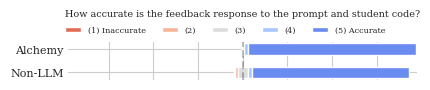

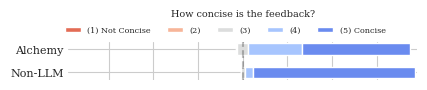

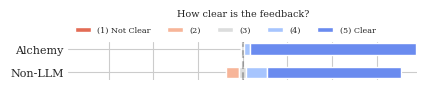

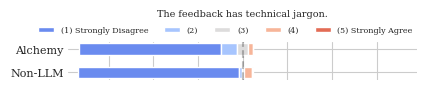

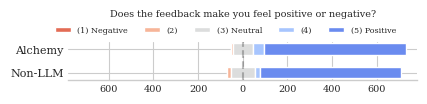

accurate:
	statistic = 323498.0 
	pvalue = 1.0169245574441002e-06 
	effectsize = 0.5317192636423406
concise:
	statistic = 212191.0 
	pvalue = 3.382991720313055e-46 
	effectsize = 0.3487689020381328
clear:
	statistic = 361697.0 
	pvalue = 1.4538539624065836e-26 
	effectsize = 0.5945052596975674
jargon:
	statistic = 334386.0 
	pvalue = 7.400482062133421e-09 
	effectsize = 0.5496153846153846
sentiment:
	statistic = 307100.0 
	pvalue = 0.6316177933316987 
	effectsize = 0.5047666009204471
Import Variables, Basic Scatter Plot, Timely Extraction Assignments Score Distribution


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


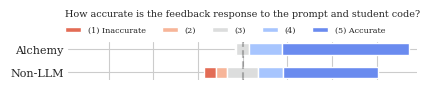

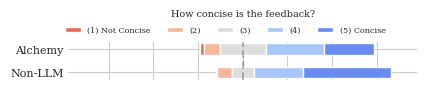

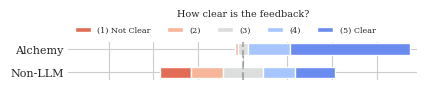

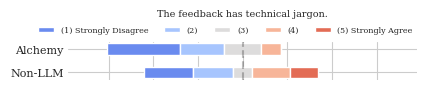

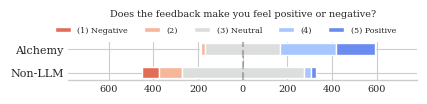

accurate:
	statistic = 375421.5 
	pvalue = 8.4047395336878e-21 
	effectsize = 0.6170636094674556
concise:
	statistic = 230413.5 
	pvalue = 2.312581312103514e-18 
	effectsize = 0.3787204142011834
clear:
	statistic = 488830.5 
	pvalue = 2.889333451468034e-107 
	effectsize = 0.8034689349112426
jargon:
	statistic = 222447.0 
	pvalue = 1.8788443097468307e-21 
	effectsize = 0.3656262327416174
sentiment:
	statistic = 471601.0 
	pvalue = 7.630644584505096e-97 
	effectsize = 0.7751495726495726
Better Pig Latin, Good Job, Highest Filter Assignments Score Distribution


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


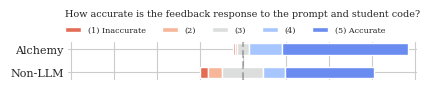

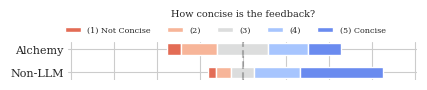

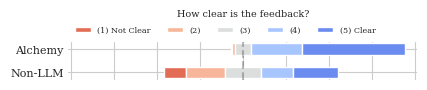

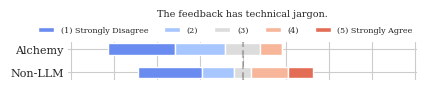

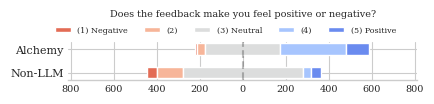

accurate:
	statistic = 416758.5 
	pvalue = 2.413667294108724e-27 
	effectsize = 0.6352057613168725
concise:
	statistic = 205969.0 
	pvalue = 5.569004765251352e-41 
	effectsize = 0.313929279073312
clear:
	statistic = 492478.5 
	pvalue = 1.7280283547478823e-75 
	effectsize = 0.7506149977137632
jargon:
	statistic = 274593.5 
	pvalue = 3.55201217751983e-09 
	effectsize = 0.4185238530711782
sentiment:
	statistic = 471845.5 
	pvalue = 3.3059685377135176e-64 
	effectsize = 0.7191670477061424


In [279]:
assignments = {
    'bakery_intro_programs_code_try_blockpy': 'Try BlockPy!',
    'bakery_structures_lists_code_emptiness': 'Emptiness',
    'bakery_structures_lists_code_book_list': 'Book List',
    'bakery_intro_import_code_import_variable': 'Import Variables',
    'bakery_advanced_plotting_code_basic_scatter': 'Basic Scatter Plot',
    'bakery_functions_flow_code_timely_extraction': 'Timely Extraction',
    'bakery_if_patterns_make_pig_latin': 'Better Pig Latin',
    'bakery_nesting_list_dataclasses_code_good_job': 'Good Job',
    'bakery_for_composition_code_highest_filter': 'Highest Filter'
}
assignment_bundles = (
    ('bakery_intro_programs_code_try_blockpy', 'bakery_structures_lists_code_emptiness', 'bakery_structures_lists_code_book_list'),
    ('bakery_intro_import_code_import_variable', 'bakery_advanced_plotting_code_basic_scatter', 'bakery_functions_flow_code_timely_extraction'),
    ('bakery_if_patterns_make_pig_latin', 'bakery_nesting_list_dataclasses_code_good_job', 'bakery_for_composition_code_highest_filter')
)

for assignment_bundle in assignment_bundles:
    results = {category: list(v.values) for category, v in df[(df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
    print(f'{", ".join(map(lambda assignment: assignments[assignment], assignment_bundle))} Assignments Score Distribution')
    diverging_stacked_bar_chart_results(results)

    for data_field in data_fields:
        gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2]))]['score']
        pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2]))]['score']
        U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
        print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))

Show more detailed information about the assignments.

In [280]:
# Easy assignments
df[(df.assignment_name == 'bakery_intro_programs_code_try_blockpy') | (df.assignment_name == 'bakery_structures_lists_code_emptiness') | (df.assignment_name == 'bakery_structures_lists_code_book_list')][['assignment_name', 'score_category', 'score']].groupby(['score_category']).describe()

score                                   
                                     count mean  std  min  25%  50%  75%  max
score_category                                                               
instructor_feedback_gpt_accurate    780.00 4.95 0.28 3.00 5.00 5.00 5.00 5.00
instructor_feedback_gpt_clear       780.00 4.94 0.30 3.00 5.00 5.00 5.00 5.00
instructor_feedback_gpt_concise     780.00 4.55 0.65 2.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_jargon      780.00 1.31 0.72 1.00 1.00 1.00 1.00 4.00
instructor_feedback_gpt_sentiment   780.00 4.68 0.70 2.00 5.00 5.00 5.00 5.00
instructor_feedback_pedal_accurate  780.00 4.80 0.65 1.00 5.00 5.00 5.00 5.00
instructor_feedback_pedal_clear     780.00 4.57 0.89 1.00 5.00 5.00 5.00 5.00
instructor_feedback_pedal_concise   780.00 4.91 0.35 3.00 5.00 5.00 5.00 5.00
instructor_feedback_pedal_jargon    780.00 1.19 0.70 1.00 1.00 1.00 1.00 5.00
instructor_feedback_pedal_sentiment 780.00 4.63 0.80 2.00 5.00 5.00 5.00 5.00

In [281]:
# Medium assignments
df[(df.assignment_name == 'bakery_intro_import_code_import_variable') | (df.assignment_name == 'bakery_advanced_plotting_code_basic_scatter') | (df.assignment_name == 'bakery_functions_flow_code_timely_extraction')][['assignment_name', 'score_category', 'score']].groupby(['score_category']).describe()

score                                   
                                     count mean  std  min  25%  50%  75%  max
score_category                                                               
instructor_feedback_gpt_accurate    780.00 4.64 0.66 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_clear       780.00 4.60 0.67 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_concise     780.00 3.78 1.03 1.00 3.00 4.00 5.00 5.00
instructor_feedback_gpt_jargon      780.00 2.03 1.05 1.00 1.00 2.00 3.00 5.00
instructor_feedback_gpt_sentiment   780.00 3.73 0.84 1.00 3.00 4.00 4.00 5.00
instructor_feedback_pedal_accurate  780.00 4.04 1.27 1.00 3.00 5.00 5.00 5.00
instructor_feedback_pedal_clear     780.00 3.11 1.40 1.00 2.00 3.00 4.00 5.00
instructor_feedback_pedal_concise   780.00 4.20 0.98 1.00 4.00 5.00 5.00 5.00
instructor_feedback_pedal_jargon    780.00 2.74 1.46 1.00 1.00 2.00 4.00 5.00
instructor_feedback_pedal_sentiment 780.00 2.78 0.79 1.00 3.00 3.00 3.00 5.00

In [282]:
# Hard assignments
df[(df.assignment_name == 'bakery_if_patterns_make_pig_latin') | (df.assignment_name == 'bakery_nesting_list_dataclasses_code_good_job') | (df.assignment_name == 'bakery_for_composition_code_highest_filter')][['assignment_name', 'score_category', 'score']].groupby(['score_category']).describe()

score                                   
                                     count mean  std  min  25%  50%  75%  max
score_category                                                               
instructor_feedback_gpt_accurate    810.00 4.61 0.74 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_clear       810.00 4.45 0.77 1.00 4.00 5.00 5.00 5.00
instructor_feedback_gpt_concise     810.00 3.24 1.21 1.00 2.00 3.00 4.00 5.00
instructor_feedback_gpt_jargon      810.00 2.07 1.05 1.00 1.00 2.00 3.00 5.00
instructor_feedback_gpt_sentiment   810.00 3.57 0.83 1.00 3.00 4.00 4.00 5.00
instructor_feedback_pedal_accurate  810.00 3.98 1.22 1.00 3.00 5.00 5.00 5.00
instructor_feedback_pedal_clear     810.00 3.23 1.38 1.00 2.00 3.00 5.00 5.00
instructor_feedback_pedal_concise   810.00 4.03 1.16 1.00 3.00 4.00 5.00 5.00
instructor_feedback_pedal_jargon    810.00 2.58 1.50 1.00 1.00 2.00 4.00 5.00
instructor_feedback_pedal_sentiment 810.00 2.90 0.80 1.00 3.00 3.00 3.00 5.00

Create graphs for each student and assignment combination displaying the score distribution, and display the significance values for each score category for each combination.

C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


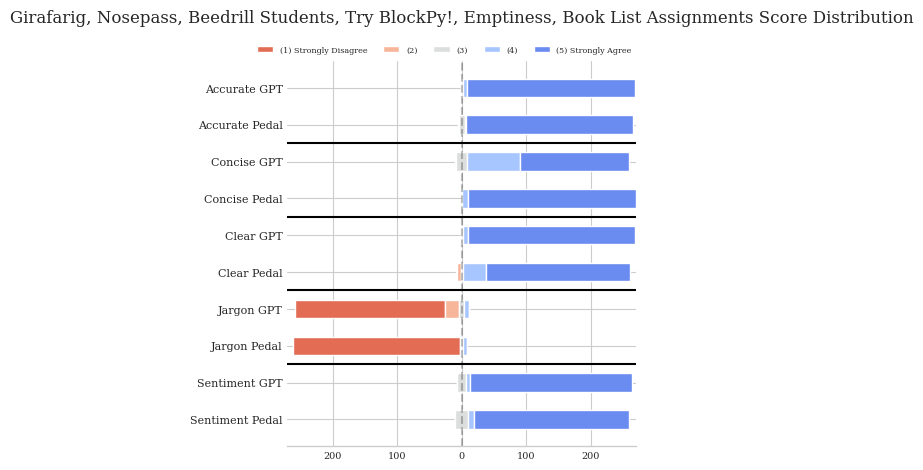

accurate:
	statistic = 1112328.0 
	pvalue = 1.8250469538047097e-50 
	effectsize = 0.7504068002428658
concise:
	statistic = 938250.0 
	pvalue = 3.08512469718343e-15 
	effectsize = 0.6329690346083788
clear:
	statistic = 1111168.0 
	pvalue = 4.909428233387908e-50 
	effectsize = 0.7496242326114821
jargon:
	statistic = 152496.0 
	pvalue = 2.0276906142576524e-119 
	effectsize = 0.10287795992714026
sentiment:
	statistic = 1086527.0 
	pvalue = 9.099176741695325e-44 
	effectsize = 0.7330007420899953


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


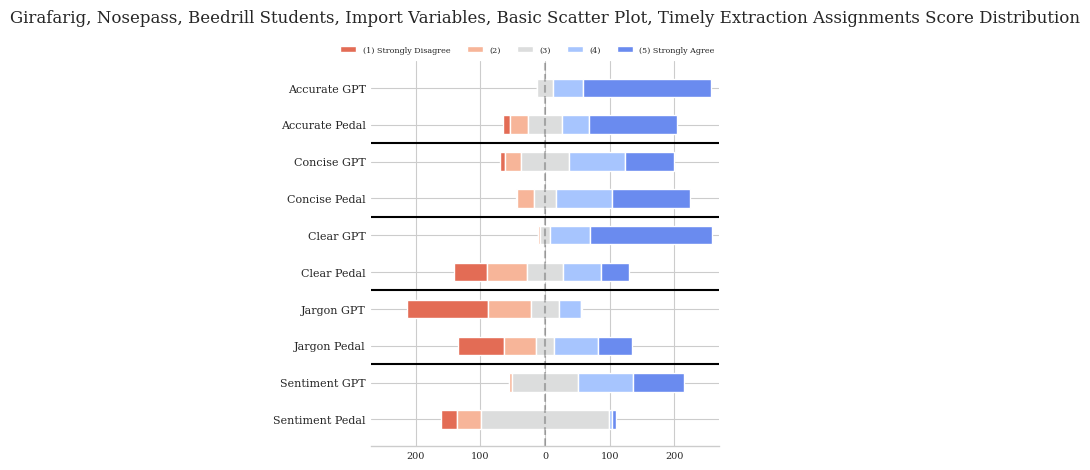

accurate:
	statistic = 989571.0 
	pvalue = 2.9530829339186196e-23 
	effectsize = 0.6675915806516899
concise:
	statistic = 686225.5 
	pvalue = 0.02925267916991242 
	effectsize = 0.4629464345948863
clear:
	statistic = 982735.0 
	pvalue = 5.591083008666517e-22 
	effectsize = 0.6629798286446739
jargon:
	statistic = 278373.0 
	pvalue = 1.2028744105268684e-74 
	effectsize = 0.1877980165958308
sentiment:
	statistic = 723930.5 
	pvalue = 0.4949618325891313 
	effectsize = 0.48838325575119745


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


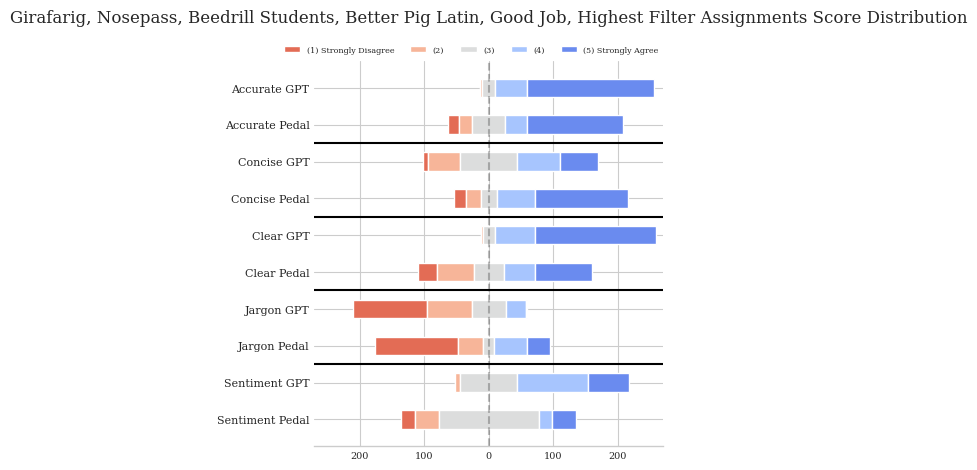

accurate:
	statistic = 985387.0 
	pvalue = 1.4439419014759378e-22 
	effectsize = 0.6647689401605613
concise:
	statistic = 602489.0 
	pvalue = 3.702568285260737e-08 
	effectsize = 0.4064555083316468
clear:
	statistic = 973654.5 
	pvalue = 1.499208881159507e-20 
	effectsize = 0.6568538757336572
jargon:
	statistic = 293255.5 
	pvalue = 5.8686955437222e-70 
	effectsize = 0.19783815691830264
sentiment:
	statistic = 694569.0 
	pvalue = 0.06471083790439126 
	effectsize = 0.468575187209067


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


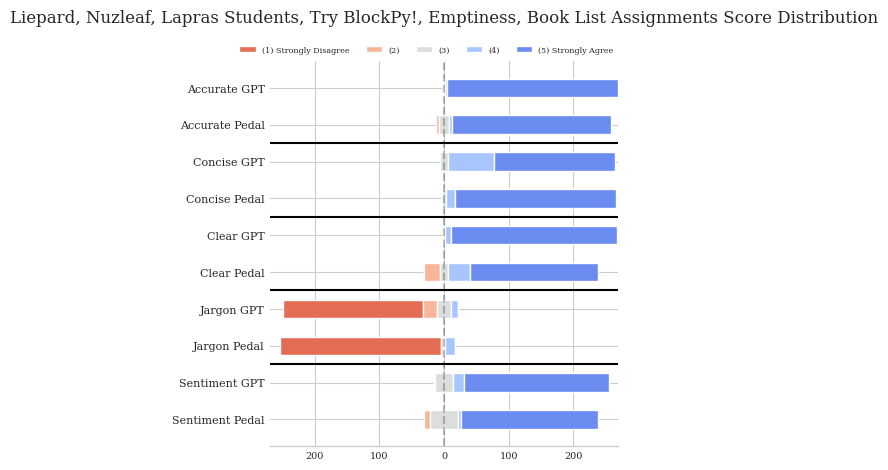

accurate:
	statistic = 1138407.0 
	pvalue = 1.2926314654038375e-56 
	effectsize = 0.7680004047763611
concise:
	statistic = 998995.5 
	pvalue = 1.2397387144145066e-24 
	effectsize = 0.6739496053430479
clear:
	statistic = 1127898.0 
	pvalue = 1.4293731615522656e-53 
	effectsize = 0.7609107468123861
jargon:
	statistic = 169983.5 
	pvalue = 4.20975943853168e-111 
	effectsize = 0.11467550428388315
sentiment:
	statistic = 1046904.5 
	pvalue = 4.85805926117943e-34 
	effectsize = 0.7062703231464615


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


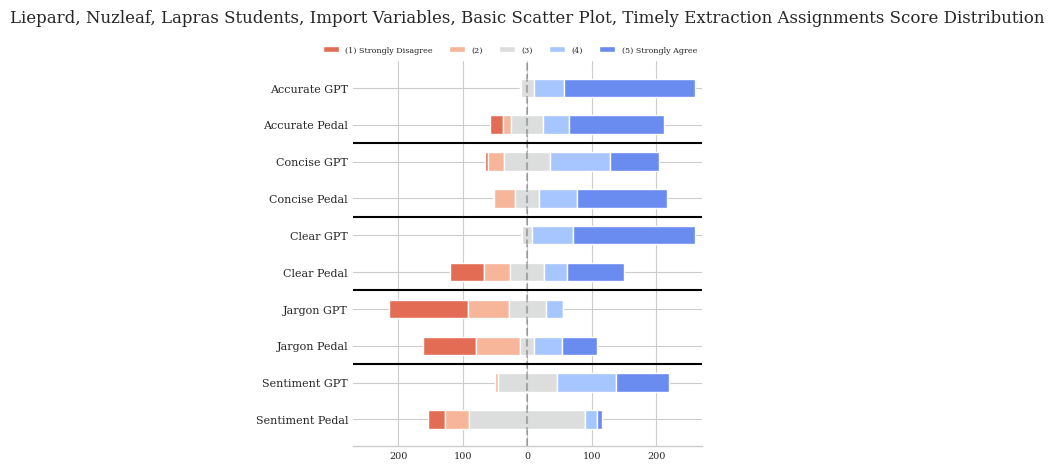

accurate:
	statistic = 1019710.0 
	pvalue = 1.9588190559071965e-28 
	effectsize = 0.687924171895028
concise:
	statistic = 714792.0 
	pvalue = 0.29864746424537447 
	effectsize = 0.4822181744586116
clear:
	statistic = 1005624.5 
	pvalue = 1.052084193732049e-25 
	effectsize = 0.6784217095054982
jargon:
	statistic = 273138.0 
	pvalue = 2.2952047139344484e-75 
	effectsize = 0.18426634284557783
sentiment:
	statistic = 756314.0 
	pvalue = 0.5503359994593049 
	effectsize = 0.5102300478985361


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


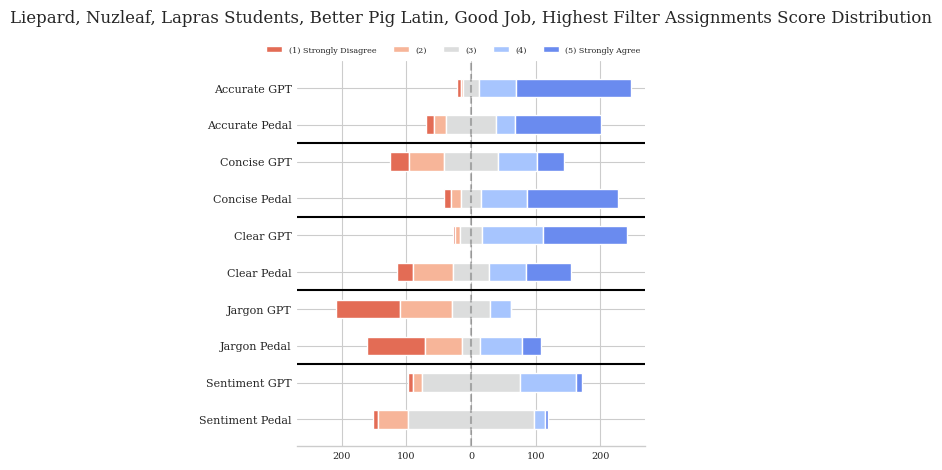

accurate:
	statistic = 961772.5 
	pvalue = 2.3399629489913547e-18 
	effectsize = 0.6488379545301222
concise:
	statistic = 538178.0 
	pvalue = 1.2739469086656931e-15 
	effectsize = 0.3630695540713756
clear:
	statistic = 871264.0 
	pvalue = 2.728761058950048e-07 
	effectsize = 0.5877784524050462
jargon:
	statistic = 302756.5 
	pvalue = 3.3610285335110014e-66 
	effectsize = 0.20424779059569587
sentiment:
	statistic = 547291.5 
	pvalue = 2.7164504678370142e-14 
	effectsize = 0.36921776968225056


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


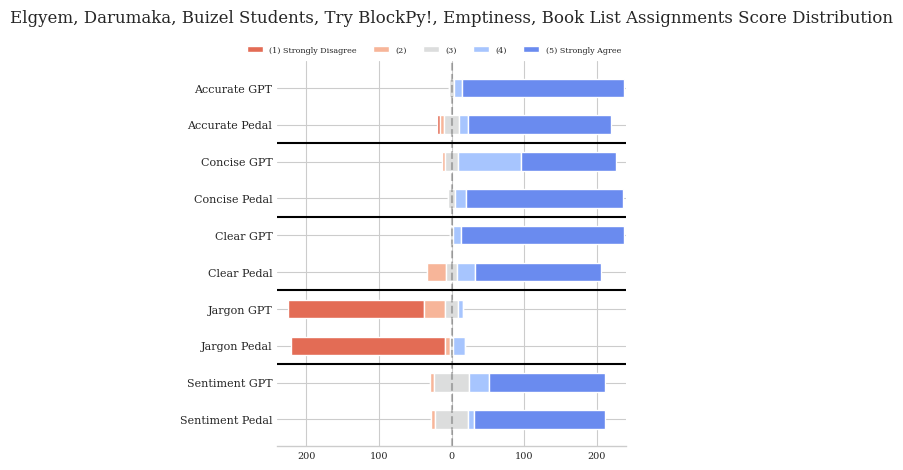

accurate:
	statistic = 930055.5 
	pvalue = 1.8772222763973796e-44 
	effectsize = 0.7510138081395349
concise:
	statistic = 767457.0 
	pvalue = 3.2417286335350317e-11 
	effectsize = 0.6197165697674418
clear:
	statistic = 935997.5 
	pvalue = 5.017358452223076e-46 
	effectsize = 0.755811934754522
jargon:
	statistic = 135557.0 
	pvalue = 5.162016222643924e-102 
	effectsize = 0.10946140180878552
sentiment:
	statistic = 787725.0 
	pvalue = 4.398681510414346e-14 
	effectsize = 0.6360828488372093


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


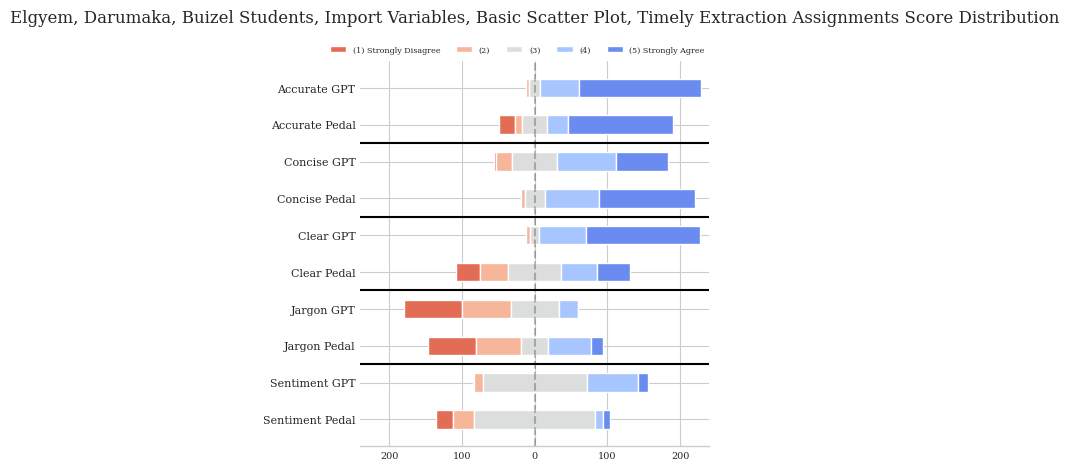

accurate:
	statistic = 835648.5 
	pvalue = 2.405531399161251e-21 
	effectsize = 0.6708802986512524
concise:
	statistic = 604097.5 
	pvalue = 0.4068504818393669 
	effectsize = 0.4849851477199743
clear:
	statistic = 821746.0 
	pvalue = 9.279977916865581e-19 
	effectsize = 0.6597190109184329
jargon:
	statistic = 260928.5 
	pvalue = 3.080236022878263e-57 
	effectsize = 0.20948017019910084
sentiment:
	statistic = 469024.0 
	pvalue = 1.1359541295131829e-11 
	effectsize = 0.37654463712267183


C:\Users\Brend\AppData\Local\Temp\ipykernel_16892\4196084247.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([str(i) for i in np.arange(-bound, bound + 1, (bound * 2) / 10)], fontsize='x-small')


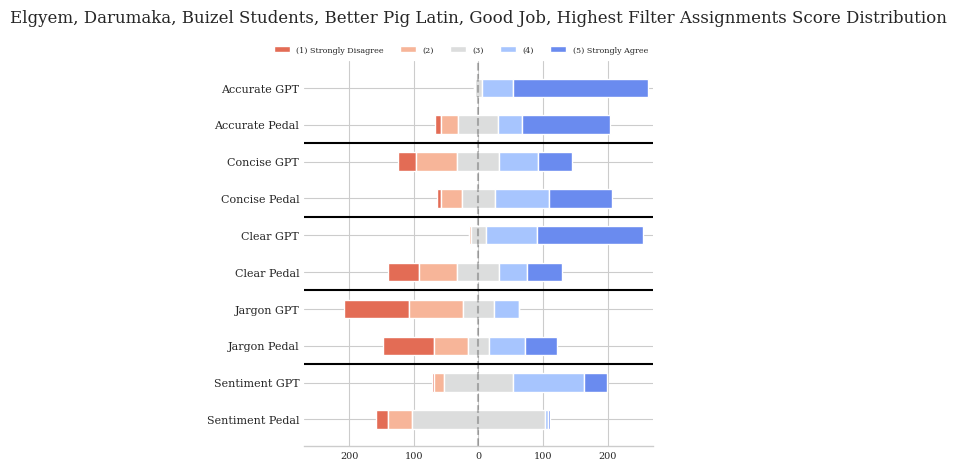

accurate:
	statistic = 980400.5 
	pvalue = 7.776147001069588e-32 
	effectsize = 0.6996364090487405
concise:
	statistic = 531386.0 
	pvalue = 2.034677567755125e-12 
	effectsize = 0.37920930564475847
clear:
	statistic = 904031.0 
	pvalue = 1.942610214700075e-17 
	effectsize = 0.6451373724398772
jargon:
	statistic = 278093.0 
	pvalue = 1.1139606127342791e-68 
	effectsize = 0.19845357881966746
sentiment:
	statistic = 602783.0 
	pvalue = 4.85997195041042e-05 
	effectsize = 0.43015985156640263


In [283]:
for student_bundle in student_bundles:
    for assignment_bundle in assignment_bundles:
        results = {category: list(v.values) for category, v in df[((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))].groupby('score_category').score.value_counts().unstack('score_category').fillna(0.0).items()}
        results_sorted = {}
        for data_field in data_fields:
            results_sorted[data_field.capitalize() + ' GPT'] = results['instructor_feedback_gpt_' + data_field]
            results_sorted[data_field.capitalize() + ' Pedal'] = results['instructor_feedback_pedal_' + data_field]
        fig, ax = diverging_stacked_bar_chart(results_sorted, f'{", ".join(student_bundle)} Students, {", ".join(map(lambda assignment: assignments[assignment], assignment_bundle))} Assignments Score Distribution')
        for i in [1.5, 3.5, 5.5, 7.5]:
            plt.axhline(y = i, color='black', linestyle='-')
        plt.show()
    
        for data_field in data_fields:
            gpt_scores = df[(df.score_category == f'instructor_feedback_gpt_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & ((df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2]))]['score']
            pedal_scores = df[(df.score_category == f'instructor_feedback_pedal_{data_field}') & ((df.assignment_name == assignment_bundle[0]) | (df.assignment_name == assignment_bundle[1]) | (df.assignment_name == assignment_bundle[2])) & (df.student_name == student_bundle[0]) | (df.student_name == student_bundle[1]) | (df.student_name == student_bundle[2])]['score']
            U, p = st.mannwhitneyu(gpt_scores, pedal_scores)
            print(data_field + ':\n\tstatistic =', U, '\n\tpvalue =', p, '\n\teffectsize =', U / (len(gpt_scores) * len(pedal_scores)))